
# **EXAMEN PARCIAL DATA MANAGMENT (2025-1)**

# **Determinantes del National Supported Work Demonstration (NSW) job-training program: aplicación de métodos de machine learning**

# Importamos librerias necesarias

In [3]:
# Esta parte debe ser corrida una sola vez

# !git clone https://github.com/maxhuppertz/hdmpy.git
# !pip uninstall -y numpy econml
# !pip install numpy
# !pip install econml

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import hdmpy
import patsy

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression, Ridge, Lasso, LogisticRegressionCV, LogisticRegression, ElasticNet
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, clone

from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.simplefilter('ignore')
np.random.seed(123)

In [4]:
# Importando desde xlsx
df = pd.read_excel('/content/experimental_control.xlsx', header = 0)
df.head(5)

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.045898
1,1,22,9,0,1,0,1,0.0,0.0,3595.894043
2,1,30,12,1,0,0,0,0.0,0.0,24909.449219
3,1,27,11,1,0,0,1,0.0,0.0,7506.145996
4,1,33,8,1,0,0,1,0.0,0.0,289.789886


In [5]:
# Verificamos que no hayan datos nulos
print(df.isnull().sum())

treat       0
age         0
educ        0
black       0
hisp        0
marr        0
nodegree    0
re74        0
re75        0
re78        0
dtype: int64


# **1. Descripción de los datos**

In [6]:
# Descrición datos cuantitativos
df.loc[:, ['age', 'educ', 're74', 're75', 're78']].describe().round(2)

,age,educ,re74,re75,re78
count,445.00,445.00,445.00,445.00,445.00
mean,25.37,10.20,2102.27,1377.14,5300.76
std,7.10,1.79,5363.58,3150.96,6631.49
min,17.00,3.00,0.00,0.00,0.00
25%,20.00,9.00,0.00,0.00,0.00
50%,24.00,10.00,0.00,0.00,3701.81
75%,28.00,11.00,824.39,1220.84,8124.71
max,55.00,16.00,39570.68,25142.24,60307.93


In [7]:
# Descripción general de datos cualitativos
dummies = ['treat', 'black', 'hisp', 'marr', 'nodegree']

tabla = pd.DataFrame()

for var in dummies:
    counts = df[var].value_counts()
    total = counts.sum()
    tabla.loc[var, 'Valor = 0'] = counts.get(0, 0)
    tabla.loc[var, '(%) cuando es 0'] = round(counts.get(0, 0) / total * 100, 2)
    tabla.loc[var, 'valor = 1'] = counts.get(1, 0)
    tabla.loc[var, '(%) cuando es 1'] = round(counts.get(1, 0) / total * 100, 2)

# Mostrar tabla final
tabla

,Valor = 0,(%) cuando es 0,valor = 1,(%) cuando es 1
treat,260.0,58.43,185.0,41.57
black,74.0,16.63,371.0,83.37
hisp,406.0,91.24,39.0,8.76
marr,370.0,83.15,75.0,16.85
nodegree,97.0,21.80,348.0,78.20


## **1.1. Descripción por grupo de control y tratamiento**

In [33]:
filtro1 = (df['treat'] == 1)
filtro2 = (df['treat'] == 0)
listCol = ['age', 'educ', 're74', 're75', 're78']
print("Tratamiento")
print(df.loc[filtro1, listCol].describe().round(2))

print("Control")
print(df.loc[filtro2, listCol].describe().round(2))

Tratamiento
          age    educ      re74      re75      re78
count  185.00  185.00    185.00    185.00    185.00
mean    25.82   10.35   2095.57   1532.06   6349.14
std      7.16    2.01   4886.62   3219.25   7867.40
min     17.00    4.00      0.00      0.00      0.00
25%     20.00    9.00      0.00      0.00    485.23
50%     25.00   11.00      0.00      0.00   4232.31
75%     29.00   12.00   1291.47   1817.28   9643.00
max     48.00   16.00  35040.07  25142.24  60307.93
Control
          age    educ      re74      re75      re78
count  260.00  260.00    260.00    260.00    260.00
mean    25.05   10.09   2107.03   1266.91   4554.80
std      7.06    1.61   5687.91   3102.98   5483.84
min     17.00    3.00      0.00      0.00      0.00
25%     19.00    9.00      0.00      0.00      0.00
50%     24.00   10.00      0.00      0.00   3138.80
75%     28.00   11.00    139.42    650.10   7288.42
max     55.00   14.00  39570.68  23031.98  39483.53


In [9]:
# Variables binarias a analizar
variables = ['black', 'hisp', 'marr', 'nodegree']

# Crear una tabla vacía
tabla_grupos = pd.DataFrame(index=variables, columns=['Control (%)', 'Tratamiento (%)'])

# Calcular proporciones por grupo
for var in variables:
    control_mean = df[df['treat'] == 0][var].mean() * 100
    treatment_mean = df[df['treat'] == 1][var].mean() * 100
    tabla_grupos.loc[var, 'Control (%)'] = round(control_mean, 2)
    tabla_grupos.loc[var, 'Tratamiento (%)'] = round(treatment_mean, 2)

# Mostrar tabla
tabla_grupos

,Control (%),Tratamiento (%)
black,82.69,84.32
hisp,10.77,5.95
marr,15.38,18.92
nodegree,83.46,70.81


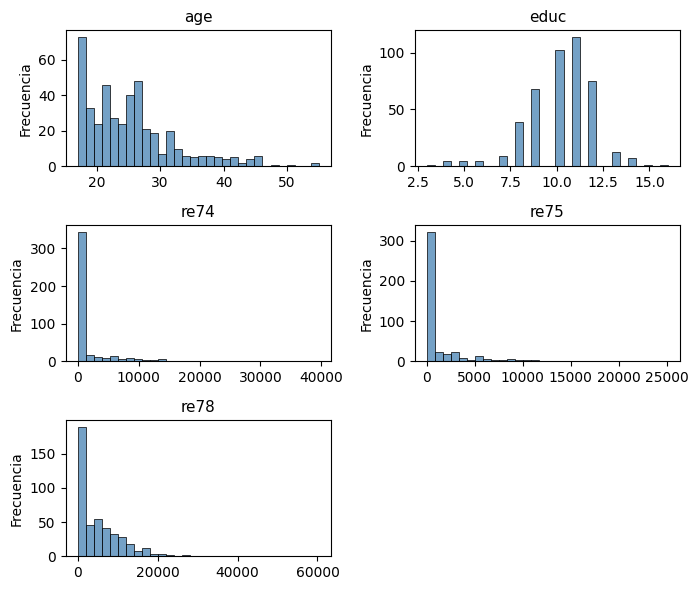

In [31]:
# Variables continuas
vars_cont = ['age', 'educ', 're74', 're75', 're78']

# Crear figura con 3 filas y 2 columnas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Graficar cada variable
for i, var in enumerate(vars_cont):
    sns.histplot(data=df, x=var, bins=30, kde=False, ax=axes[i], color='steelblue')
    axes[i].set_title(f'{var}', fontsize=11)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

# Eliminar el último eje vacío si sobran
if len(vars_cont) < len(axes):
    for j in range(len(vars_cont), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig("Hist. var. cuanti. general..png", dpi=300)
plt.show()

## **1.2. Descripción de edad, años de educación y salarios anuales**

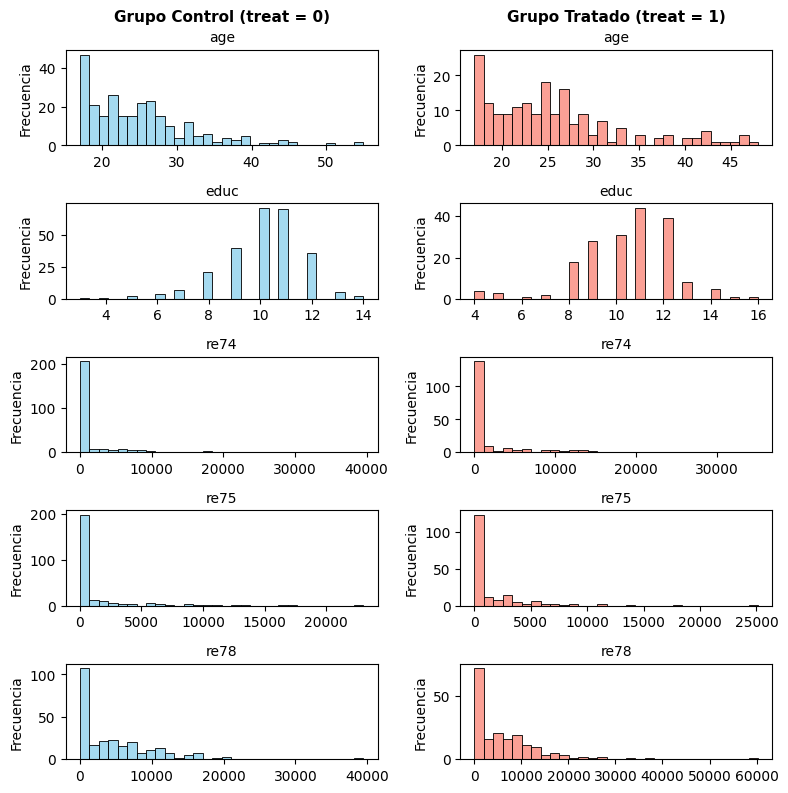

In [21]:
# Variables continuas
vars_cont = ['age', 'educ', 're74', 're75', 're78']

# Crear figura y ejes: 5 filas (una por variable), 2 columnas (treat=0 y treat=1)
fig, axes = plt.subplots(nrows=len(vars_cont), ncols=2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.6)  # Espaciado vertical

# Iterar sobre variables y dibujar histogramas
for i, var in enumerate(vars_cont):
    # Grupo control
    sns.histplot(data=df[df['treat'] == 0], x=var, bins=30, kde=False, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_xlabel('')  # Quitar etiqueta del eje x
    axes[i, 0].set_ylabel('Frecuencia')
    axes[i, 0].set_title(f'{var}', fontsize=10)

    # Grupo tratado
    sns.histplot(data=df[df['treat'] == 1], x=var, bins=30, kde=False, ax=axes[i, 1], color='salmon')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('Frecuencia')
    axes[i, 1].set_title(f'{var}', fontsize=10)

# Títulos generales por columna (arriba de la figura)
axes[0, 0].annotate('Grupo Control (treat = 0)', xy=(0.5, 1.3), xycoords='axes fraction',
                    ha='center', fontsize=11, weight='bold')
axes[0, 1].annotate('Grupo Tratado (treat = 1)', xy=(0.5, 1.3), xycoords='axes fraction',
                    ha='center', fontsize=11, weight='bold')

plt.tight_layout()
# plt.savefig("Hist. var. cuanti.png", dpi=300)
plt.show()

In [34]:
# Filtros para analizar grupos de tratamiento y control
filtro_treat = (df['treat'] == 1)
filtro_control = (df['treat'] == 0)

# Filtros de salarios anuales antes y después del programa
filtro1 = (df['re74'] == 0) & (df['re75'] == 0) & (df['re78'] > 0) # personas sin ingresos previos
filtro2 = (df['re74'] == 0) & (df['re75'] > 0) & (df['re78'] > 0) # personas con ingresos previos bajos
filtro3 = (df['re74'] > 0) & (df['re75'] > 0) & (df['re78'] > 0) # personas con ingresos previos medios

listCol = ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're78']

In [35]:
# Nuevo data frame con filtro de salarios
df_filtro1 = df.loc[filtro1, listCol]
df_filtro2 = df.loc[filtro2, listCol]
df_filtro3 = df.loc[filtro3, listCol]

# Nuevos data frames de tratamiento con filtros de salarios
df_treat1 = df.loc[filtro_treat & filtro1, listCol]
df_treat2 = df.loc[filtro_treat & filtro2, listCol]
df_treat3 = df.loc[filtro_treat & filtro3, listCol]

# Nuevos data frames de control con filtros de salarios
df_control1 = df.loc[filtro_control & filtro1, listCol]
df_control2 = df.loc[filtro_control & filtro2, listCol]
df_control3 = df.loc[filtro_control & filtro3, listCol]

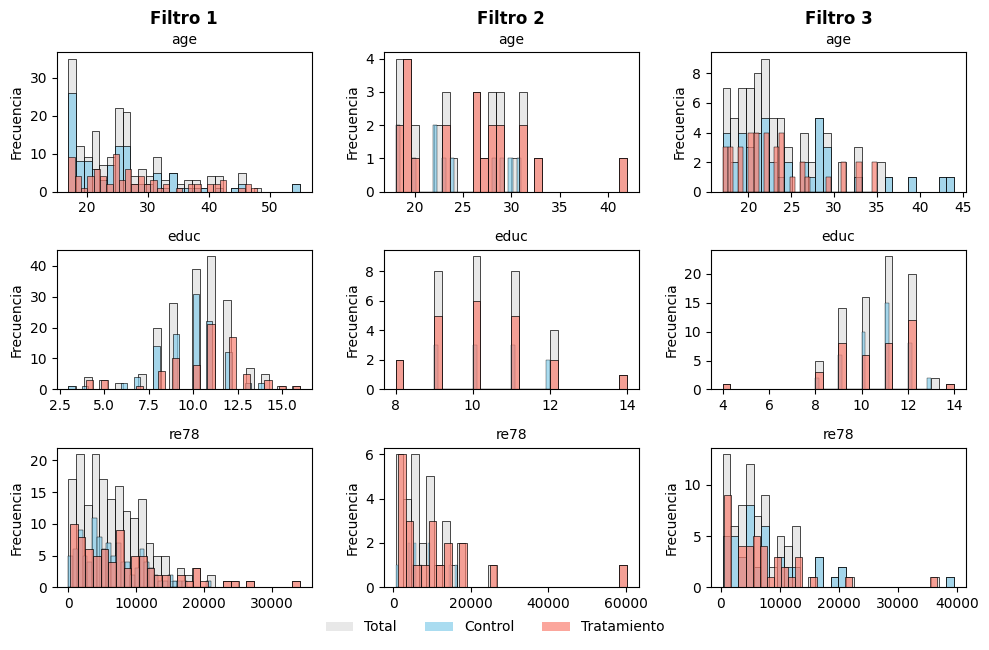

In [42]:
# Variables y configuración
vars_plot = ['age', 'educ', 're78']
filtros = [1, 2, 3]
colors = {'Total': 'lightgrey', 'Control': 'skyblue', 'Tratamiento': 'salmon'}

# Crear figura
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7), sharex=False)
fig.subplots_adjust(hspace=0.6, top=0.92)  # espacio vertical y margen superior

# Iterar por variable (fila) y filtro (columna)
for i, var in enumerate(vars_plot):
    for j, f in enumerate(filtros):
        # Subgráfico actual
        ax = axes[i, j]

        # DataFrames filtrados
        df_total = eval(f'df_filtro{f}')
        df_control = eval(f'df_control{f}')
        df_treat = eval(f'df_treat{f}')

        # Graficar histogramas
        sns.histplot(df_total[var], bins=30, kde=False, color=colors['Total'], ax=ax, alpha=0.5)
        axes[i, j].set_xlabel('')  # Quitar etiqueta del eje x
        axes[i, j].set_title(f'{var}', fontsize=10)
        axes[i, j].set_ylabel('Frecuencia')

        sns.histplot(df_control[var], bins=30, kde=False, color=colors['Control'], ax=ax, alpha=0.7)
        axes[i, j].set_xlabel('')  # Quitar etiqueta del eje x
        axes[i, j].set_title(f'{var}', fontsize=10)
        axes[i, j].set_ylabel('Frecuencia')

        sns.histplot(df_treat[var], bins=30, kde=False, color=colors['Tratamiento'], ax=ax, alpha=0.7)
        axes[i, j].set_xlabel('')  # Quitar etiqueta del eje x
        axes[i, j].set_title(f'{var}', fontsize=10)
        axes[i, j].set_ylabel('Frecuencia')

# Subtítulos generales por columna arriba
for j, f in enumerate(filtros):
    axes[0, j].annotate(f"Filtro {f}", xy=(0.5, 1.2), xycoords='axes fraction',
                        ha='center', fontsize=12, weight='bold')

# Leyenda general al final (fuera del grid)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors['Total'], label='Total', alpha=0.5),
                   Patch(facecolor=colors['Control'], label='Control', alpha=0.7),
                   Patch(facecolor=colors['Tratamiento'], label='Tratamiento', alpha=0.7)]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, frameon=False, bbox_to_anchor=(0.5, 0.02))

# Ajustar layout para que no se solapen
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # deja espacio abajo para leyenda
# plt.savefig("Hist. filtrada.png", dpi=300)
plt.show()

## **1.3. Descripción de personas de raza negra, hispanos, casadas y sin título académico**

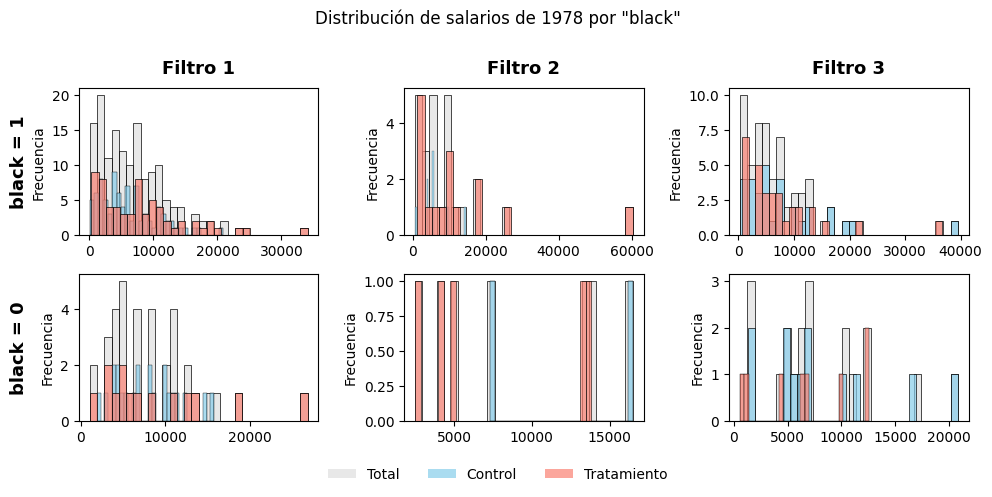

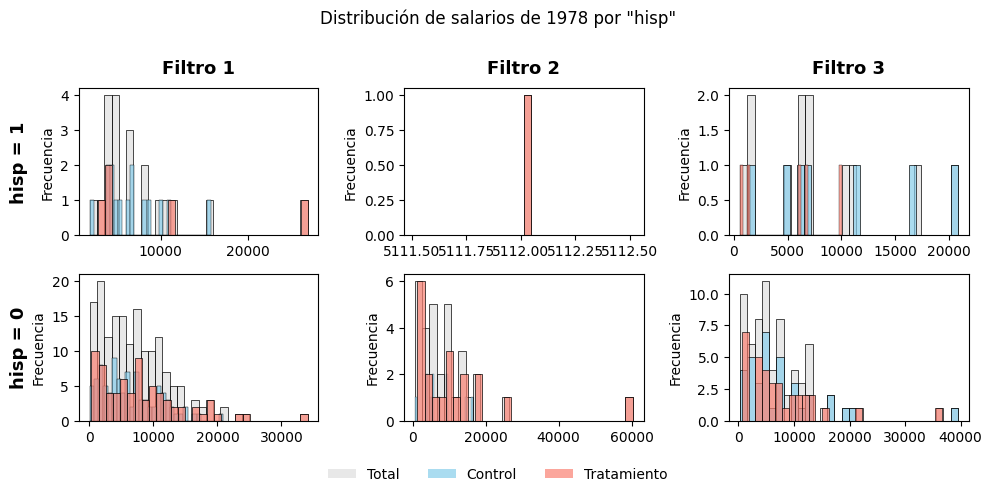

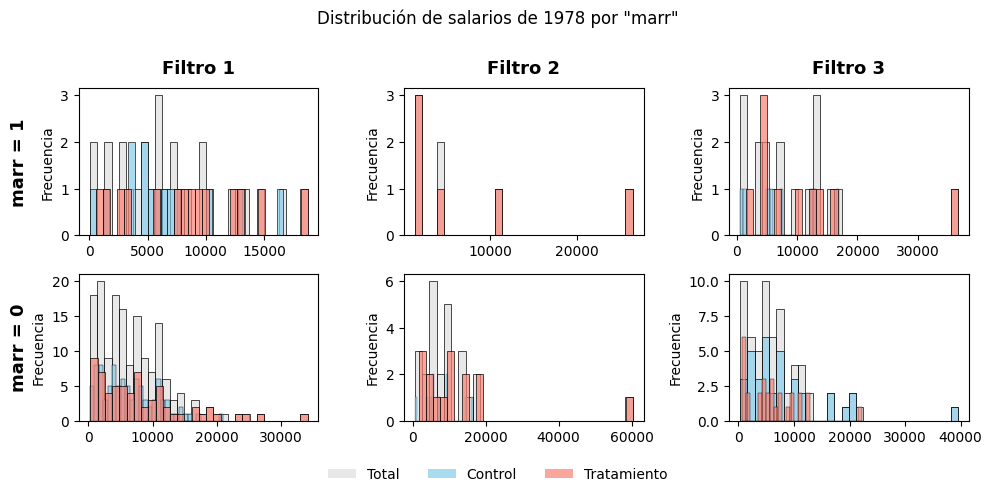

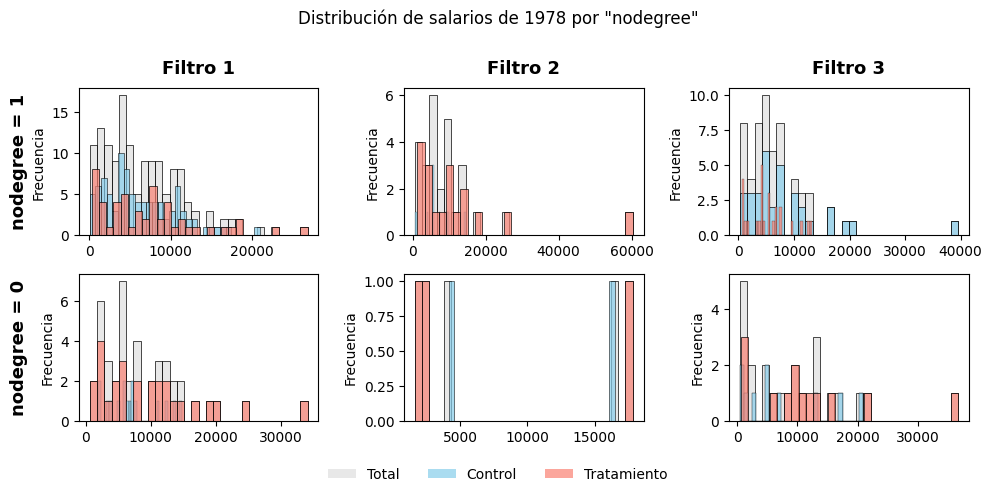

In [47]:
from matplotlib.patches import Patch

# Variables descriptivas
caracteristicas = ['black', 'hisp', 'marr', 'nodegree']
filtros = [1, 2, 3]
colors = {'Total': 'lightgrey', 'Control': 'skyblue', 'Tratamiento': 'salmon'}

# Loop por cada característica
for carac in caracteristicas:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), sharex=False)
    fig.subplots_adjust(hspace=0.4, top=0.9)
    fig.suptitle(f'Distribución de salarios de 1978 por "{carac}"', fontsize=12, y=0.95)

    for i, val in enumerate([1, 0]):  # Fila: carac=1 y carac=0
        for j, f in enumerate(filtros):  # Columna: filtro1,2,3
            ax = axes[i, j]

            # Recuperar los dataframes existentes
            df_total = eval(f'df_filtro{f}')
            df_control = eval(f'df_control{f}')
            df_treat = eval(f'df_treat{f}')

            # Aplicar filtro por característica (1 o 0)
            df_total_filt = df_total[df_total[carac] == val]
            df_control_filt = df_control[df_control[carac] == val]
            df_treat_filt = df_treat[df_treat[carac] == val]

            # Graficar cada uno con su color
            sns.histplot(df_total_filt['re78'], bins=30, kde=False, color=colors['Total'], ax=ax, alpha=0.5)
            sns.histplot(df_control_filt['re78'], bins=30, kde=False, color=colors['Control'], ax=ax, alpha=0.7)
            sns.histplot(df_treat_filt['re78'], bins=30, kde=False, color=colors['Tratamiento'], ax=ax, alpha=0.7)

            # Título de cada subgráfico
            ax.set_title('')
            ax.set_xlabel('')
            ax.set_ylabel('Frecuencia')

    # Subtítulos por columna (arriba)
    for j, f in enumerate(filtros):
        axes[0, j].annotate(f"Filtro {f}", xy=(0.5, 1.1), xycoords='axes fraction',
                            ha='center', fontsize=13, weight='bold')

    # Subtítulos por fila (izquierda)
    axes[0, 0].annotate(f'{carac} = 1', xy=(-0.25, 0.5), xycoords='axes fraction',
                        ha='center', va='center', fontsize=13, rotation=90, weight='bold')
    axes[1, 0].annotate(f'{carac} = 0', xy=(-0.25, 0.5), xycoords='axes fraction',
                        ha='center', va='center', fontsize=13, rotation=90, weight='bold')

    # Leyenda general
    legend_elements = [Patch(facecolor=colors['Total'], label='Total', alpha=0.5),
                       Patch(facecolor=colors['Control'], label='Control', alpha=0.7),
                       Patch(facecolor=colors['Tratamiento'], label='Tratamiento', alpha=0.7)]

    fig.legend(handles=legend_elements, loc='center', ncol=3, fontsize=10, frameon=False, bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # deja espacio abajo para leyenda
    plt.show()


## Estadística descriptiva por filtro y característica

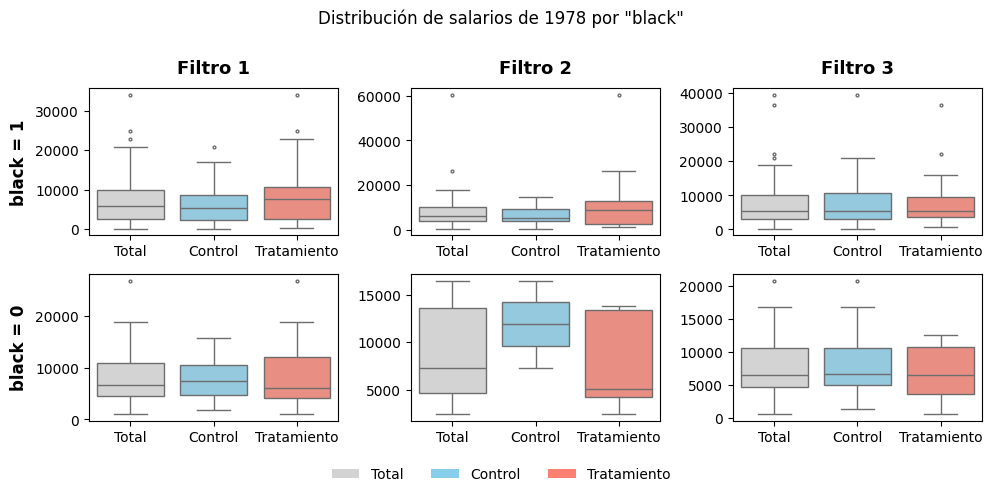

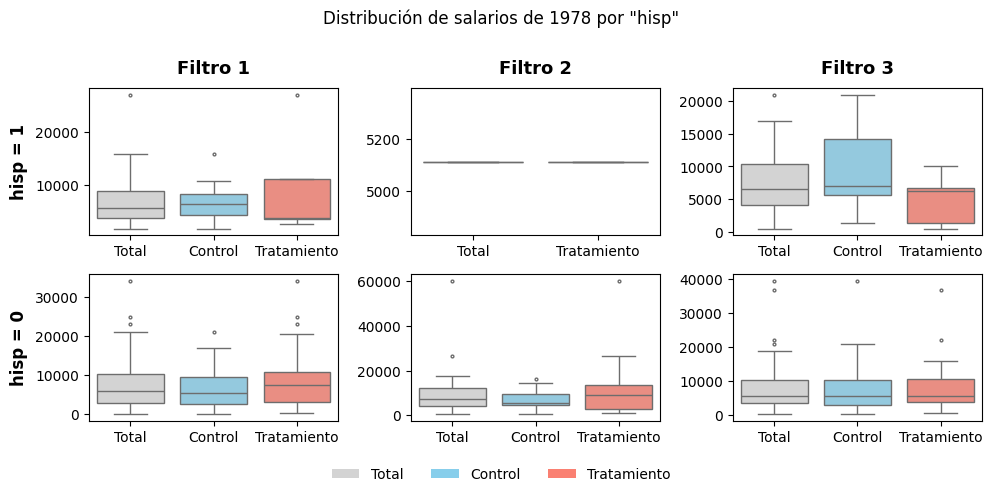

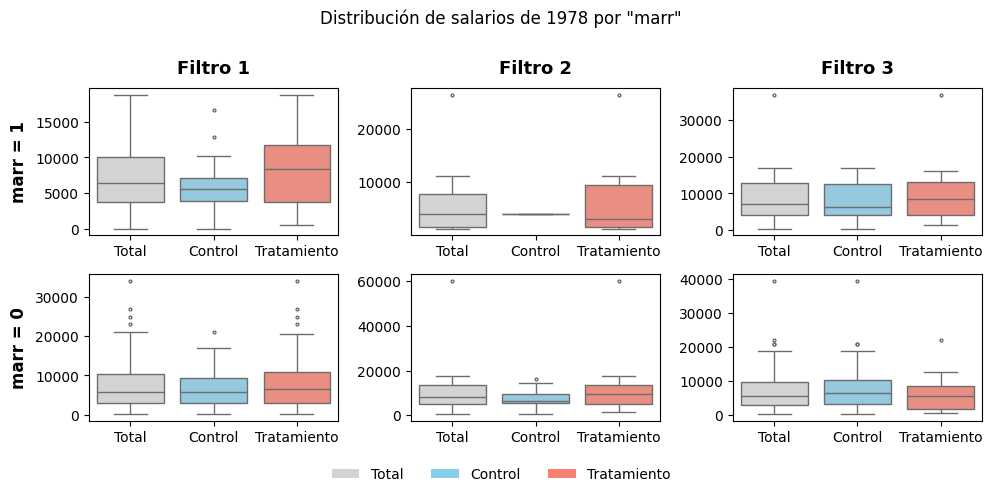

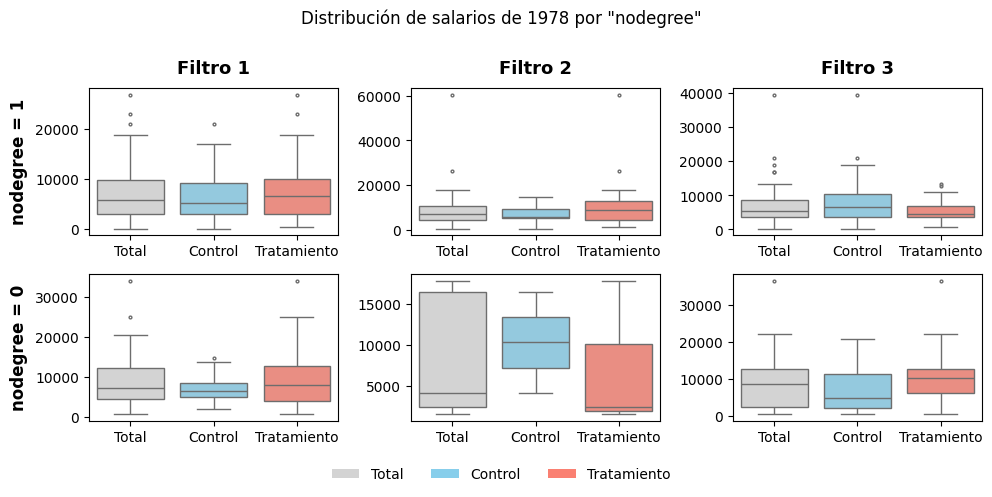

In [52]:
caracteristicas = ['black', 'hisp', 'marr', 'nodegree']
filtros = [1, 2, 3]
colors = {'Total': 'lightgrey', 'Control': 'skyblue', 'Tratamiento': 'salmon'}

for carac in caracteristicas:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), sharex=False)
    fig.subplots_adjust(hspace=0.4, top=0.9)
    fig.suptitle(f'Distribución de salarios de 1978 por "{carac}"', fontsize=12, y=0.95)

    for i, val in enumerate([1, 0]):  # Fila: carac=1 y carac=0
        for j, f in enumerate(filtros):  # Columna: filtro1,2,3
            ax = axes[i, j]

            # Recuperar los dataframes
            df_total = eval(f'df_filtro{f}')
            df_control = eval(f'df_control{f}')
            df_treat = eval(f'df_treat{f}')

            # Aplicar filtro por valor de característica
            df_total_filt = df_total[df_total[carac] == val].copy()
            df_control_filt = df_control[df_control[carac] == val].copy()
            df_treat_filt = df_treat[df_treat[carac] == val].copy()

            # Añadir columna de grupo
            df_total_filt['Grupo'] = 'Total'
            df_control_filt['Grupo'] = 'Control'
            df_treat_filt['Grupo'] = 'Tratamiento'

            # Concatenar en un solo dataframe
            df_box = pd.concat([df_total_filt, df_control_filt, df_treat_filt])

            # Boxplot
            sns.boxplot(data=df_box, x='Grupo', y='re78', ax=ax,
                        palette=colors, fliersize=2)

            ax.set_title('')
            ax.set_xlabel('')
            ax.set_ylabel('')

    # Subtítulos por columna (filtros)
    for j, f in enumerate(filtros):
        axes[0, j].annotate(f"Filtro {f}", xy=(0.5, 1.1), xycoords='axes fraction',
                            ha='center', fontsize=13, weight='bold')

    # Subtítulos por fila (valores de la característica)
    axes[0, 0].annotate(f'{carac} = 1', xy=(-0.28, 0.5), xycoords='axes fraction',
                        ha='center', va='center', fontsize=12, rotation=90, weight='bold')
    axes[1, 0].annotate(f'{carac} = 0', xy=(-0.28, 0.5), xycoords='axes fraction',
                        ha='center', va='center', fontsize=12, rotation=90, weight='bold')

    # Leyenda general
    legend_elements = [Patch(facecolor=colors['Total'], label='Total'),
                       Patch(facecolor=colors['Control'], label='Control'),
                       Patch(facecolor=colors['Tratamiento'], label='Tratamiento')]

    fig.legend(handles=legend_elements, loc='center', ncol=3, fontsize=10, frameon=False, bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

In [53]:
# Estadística de personas negras
# Iterar por filtros
resumen = []

for i in [1, 2, 3]:
    for grupo, nombre in zip(
        [eval(f'df_filtro{i}'), eval(f'df_treat{i}'), eval(f'df_control{i}')],
        ['Total', 'Tratamiento', 'Control']
    ):
        stats = grupo.groupby('black')['re78'].agg(Mínimo='min', Promedio='mean', Máximo='max').round(2)
        for black_value in stats.index:
            resumen.append({
                'Filtro': i,
                'Grupo': nombre,
                'black': black_value,
                'Mínimo': stats.loc[black_value, 'Mínimo'],
                'Promedio': stats.loc[black_value, 'Promedio'],
                'Máximo': stats.loc[black_value, 'Máximo']
            })

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas para mejor lectura
resumen_df = resumen_df[['Filtro', 'Grupo', 'black', 'Mínimo', 'Promedio', 'Máximo']]

# Mostrar resultado ordenado por Filtro y Grupo
print(resumen_df.sort_values(['Filtro', 'Grupo', 'black']).to_string(index=False))


 Filtro       Grupo  black  Mínimo  Promedio   Máximo
      1     Control      0 1859.17   7826.62 15791.13
      1     Control      1   44.76   6103.89 20942.24
      1       Total      0 1048.43   8221.84 26817.60
      1       Total      1   44.76   6949.18 34099.28
      1 Tratamiento      0 1048.43   8842.91 26817.60
      1 Tratamiento      1  289.79   8080.59 34099.28
      2     Control      0 7300.50  11888.76 16477.02
      2     Control      1  604.20   6509.03 14527.88
      2       Total      0 2484.55   8974.55 16477.02
      2       Total      1  604.20  10034.40 60307.93
      2 Tratamiento      0 2484.55   7808.87 13829.62
      2 Tratamiento      1 1294.41  12017.41 60307.93
      3     Control      0 1324.54   8197.37 20857.84
      3     Control      1  284.66   8164.74 39483.53
      3       Total      0  559.44   7642.45 20857.84
      3       Total      1  284.66   7806.04 39483.53
      3 Tratamiento      0  559.44   6810.06 12590.71
      3 Tratamiento      1  

In [54]:
# Estadística de personas hispanas
# Iterar por filtros
resumen = []

for i in [1, 2, 3]:
    for grupo, nombre in zip(
        [eval(f'df_filtro{i}'), eval(f'df_treat{i}'), eval(f'df_control{i}')],
        ['Total', 'Tratamiento', 'Control']
    ):
        stats = grupo.groupby('hisp')['re78'].agg(Mínimo='min', Promedio='mean', Máximo='max').round(2)
        for hisp_value in stats.index:
            resumen.append({
                'Filtro': i,
                'Grupo': nombre,
                'hisp': hisp_value,
                'Mínimo': stats.loc[hisp_value, 'Mínimo'],
                'Promedio': stats.loc[hisp_value, 'Promedio'],
                'Máximo': stats.loc[hisp_value, 'Máximo']
            })

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas para mejor lectura
resumen_df = resumen_df[['Filtro', 'Grupo', 'hisp', 'Mínimo', 'Promedio', 'Máximo']]

# Mostrar resultado ordenado por Filtro y Grupo
print(resumen_df.sort_values(['Filtro', 'Grupo', 'hisp']).to_string(index=False))

 Filtro       Grupo  hisp  Mínimo  Promedio   Máximo
      1     Control     0   44.76   6400.79 20942.24
      1     Control     1 1859.17   6769.98 15791.13
      1       Total     0   44.76   7157.66 34099.28
      1       Total     1 1859.17   7488.76 26817.60
      1 Tratamiento     0  289.79   8119.10 34099.28
      1 Tratamiento     1 2787.96   9645.12 26817.60
      2     Control     0  604.20   7487.16 16477.02
      2       Total     0  604.20   9953.86 60307.93
      2       Total     1 5112.01   5112.01  5112.01
      2 Tratamiento     0 1294.41  11310.55 60307.93
      2 Tratamiento     1 5112.01   5112.01  5112.01
      3     Control     0  284.66   7849.03 39483.53
      3     Control     1 1324.54   9844.33 20857.84
      3       Total     0  284.66   7755.76 39483.53
      3       Total     1  559.44   7826.70 20857.84
      3 Tratamiento     0  671.33   7657.00 36646.95
      3 Tratamiento     1  559.44   5002.01 10092.83


In [55]:
# Estadística de personas casadas
# Iterar por filtros
resumen = []

for i in [1, 2, 3]:
    for grupo, nombre in zip(
        [eval(f'df_filtro{i}'), eval(f'df_treat{i}'), eval(f'df_control{i}')],
        ['Total', 'Tratamiento', 'Control']
    ):
        stats = grupo.groupby('marr')['re78'].agg(Mínimo='min', Promedio='mean', Máximo='max').round(2)
        for marr_value in stats.index:
            resumen.append({
                'Filtro': i,
                'Grupo': nombre,
                'marr': marr_value,
                'Mínimo': stats.loc[marr_value, 'Mínimo'],
                'Promedio': stats.loc[marr_value, 'Promedio'],
                'Máximo': stats.loc[marr_value, 'Máximo']
            })

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas para mejor lectura
resumen_df = resumen_df[['Filtro', 'Grupo', 'marr', 'Mínimo', 'Promedio', 'Máximo']]

# Mostrar resultado ordenado por Filtro y Grupo
print(resumen_df.sort_values(['Filtro', 'Grupo', 'marr']).to_string(index=False))

 Filtro       Grupo  marr  Mínimo  Promedio   Máximo
      1     Control     0  202.28   6458.89 20942.24
      1     Control     1   44.76   6402.07 16658.25
      1       Total     0  202.28   7164.67 34099.28
      1       Total     1   44.76   7354.13 18739.93
      1 Tratamiento     0  289.79   8196.19 34099.28
      1 Tratamiento     1  590.78   8306.18 18739.93
      2     Control     0  604.20   7837.60 16477.02
      2     Control     1 3982.80   3982.80  3982.80
      2       Total     0  604.20  10533.32 60307.93
      2       Total     1 1294.41   7192.69 26372.28
      2 Tratamiento     0 1652.64  12330.46 60307.93
      2 Tratamiento     1 1294.41   7727.67 26372.28
      3     Control     0  284.66   8281.19 39483.53
      3     Control     1  499.26   7704.25 16988.18
      3       Total     0  284.66   7285.16 39483.53
      3       Total     1  499.26   9476.29 36646.95
      3 Tratamiento     0  559.44   6083.06 22163.25
      3 Tratamiento     1 1424.94  10893.93 36

In [56]:
# Estadística de personas sin título académico
# Iterar por filtros
resumen = []

for i in [1, 2, 3]:
    for grupo, nombre in zip(
        [eval(f'df_filtro{i}'), eval(f'df_treat{i}'), eval(f'df_control{i}')],
        ['Total', 'Tratamiento', 'Control']
    ):
        stats = grupo.groupby('nodegree')['re78'].agg(Mínimo='min', Promedio='mean', Máximo='max').round(2)
        for nodegree_value in stats.index:
            resumen.append({
                'Filtro': i,
                'Grupo': nombre,
                'nodegree': nodegree_value,
                'Mínimo': stats.loc[nodegree_value, 'Mínimo'],
                'Promedio': stats.loc[nodegree_value, 'Promedio'],
                'Máximo': stats.loc[nodegree_value, 'Máximo']
            })

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas para mejor lectura
resumen_df = resumen_df[['Filtro', 'Grupo', 'nodegree', 'Mínimo', 'Promedio', 'Máximo']]

# Mostrar resultado ordenado por Filtro y Grupo
print(resumen_df.sort_values(['Filtro', 'Grupo', 'nodegree']).to_string(index=False))

 Filtro       Grupo  nodegree  Mínimo  Promedio   Máximo
      1     Control         0 1890.94   7212.97 14792.90
      1     Control         1   44.76   6320.60 20942.24
      1       Total         0  647.20   8844.37 34099.28
      1       Total         1   44.76   6703.13 26817.60
      1 Tratamiento         0  647.20   9811.12 34099.28
      1 Tratamiento         1  289.79   7387.28 26817.60
      2     Control         0 4159.92  10318.47 16477.02
      2     Control         1  604.20   6857.99 14527.88
      2       Total         0 1652.64   8517.82 17814.98
      2       Total         1  604.20  10040.47 60307.93
      2 Tratamiento         0 1652.64   7317.39 17814.98
      2 Tratamiento         1 1294.41  11631.71 60307.93
      3     Control         0  439.69   7269.87 20893.11
      3     Control         1  284.66   8447.78 39483.53
      3       Total         0  439.69   9580.79 36646.95
      3       Total         1  284.66   7058.73 39483.53
      3 Tratamiento         0  

# **2. Estimación de modelo Random Forest**

In [57]:
# Establecemos los datos
y = df["re78"] # variable de interés
d = df["treat"] # variable de tratamiento o control
X = df[df.columns[~df.columns.isin(['treat','re78'])]]

In [58]:
# Hallamos efecto de tratamiento promedio (ATE)
# 1. Forma de resta en medias
mean_treated = df[df["treat"] == 1]["re78"].mean()
mean_control = df[df["treat"] == 0]["re78"].mean()
ate = mean_treated - mean_control

print(f"Average Treatment Effect (ATE): {ate:.2f}")

Average Treatment Effect (ATE): 1794.34


In [59]:
# 2. Regresion OLS
smf.ols('y ~ d', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4554.8011,408.046,11.162,0.000,3752.855,5356.747
d,1794.3424,632.853,2.835,0.005,550.574,3038.110


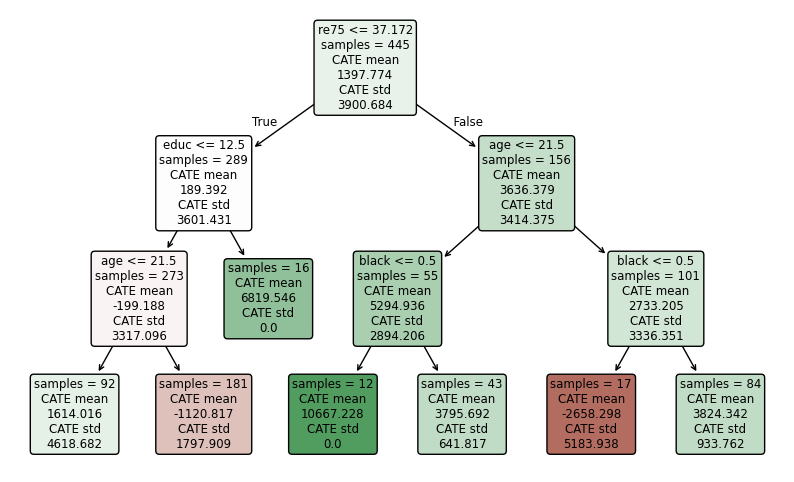

In [81]:
# Estimación de Random Forest
# Primero observamos un Arbol Causal para vista preliminar
np.random.seed(0)

tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=4)
tree_model = tree_model.fit(Y=df['re78'], X=X, T=df['treat'])

# Graphic
intrp = SingleTreeCateInterpreter(max_depth=3).interpret(tree_model, X)
plt.figure(figsize=(10, 6))
intrp.plot(feature_names=X.columns.tolist(), fontsize=8.5)
plt.show()

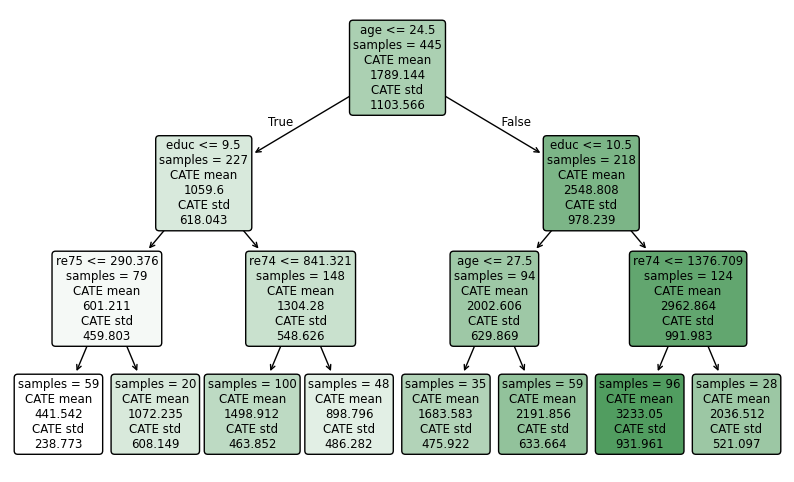

In [78]:
# CAUSAL FOREST
np.random.seed(1)

forest_model = CausalForestDML(max_depth=4)
forest_model = forest_model.fit(Y=y,X=X,T=d)

# Graphic
intrp = SingleTreeCateInterpreter(max_depth=3).interpret(forest_model, X)

plt.figure(figsize=(10, 6))
intrp.plot(feature_names=X.columns.tolist(), fontsize=8.5)
plt.show()

In [79]:
# Relevance of the variables:
pd.DataFrame({"variable": X.columns.tolist(), "importance": forest_model.feature_importances()})

,variable,importance
0,age,0.281265
1,educ,0.174172
2,black,0.095267
3,hisp,0.020441
4,marr,0.016829
5,nodegree,0.026068
6,re74,0.171103
7,re75,0.214855


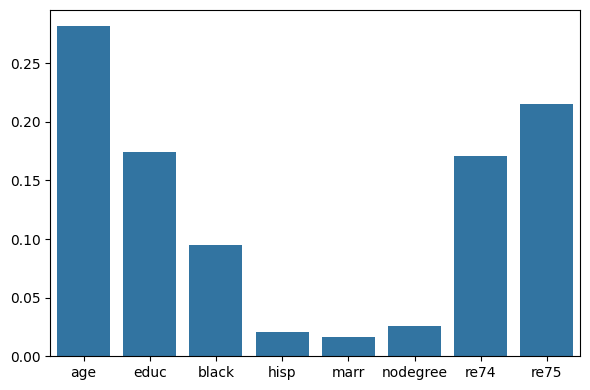

In [83]:
# Crear una lista con los nombres de las características
feature_names = X.columns.tolist()

# Crear el gráfico de barras para las importancias de las características
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=feature_names, y=forest_model.feature_importances_, color='C0', ax=ax)
#.set(title='Importancia de los Features', ylabel='Importance')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Las variables con mayor importancia son age, re75, re74 y educ.

In [187]:
# predicted_effects
df['predicted_effects'] = forest_model.effect(X)
df

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,predicted_effects,age_bins,re74_bins,re75_bins
0,1,37,11,1,0,1,1,0.000000,0.000000,9930.045898,2932.202109,35,0.0,0.0
1,1,22,9,0,1,0,1,0.000000,0.000000,3595.894043,774.258917,20,0.0,0.0
2,1,30,12,1,0,0,0,0.000000,0.000000,24909.449219,3737.445234,30,0.0,0.0
3,1,27,11,1,0,0,1,0.000000,0.000000,7506.145996,2397.850417,25,0.0,0.0
4,1,33,8,1,0,0,1,0.000000,0.000000,289.789886,2393.414386,30,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0,21,9,1,0,0,1,31886.429688,12357.219727,0.000000,1809.647295,20,31500.0,12000.0
441,0,28,11,1,0,0,1,17491.449219,13371.250000,0.000000,2230.497726,25,17000.0,13000.0
442,0,29,9,0,1,0,1,9594.307617,16341.160156,16900.300781,778.112419,25,9500.0,16000.0
443,0,25,9,1,0,1,1,24731.619141,16946.630859,7343.963867,2277.266569,25,24500.0,16500.0


In [195]:
# Definimos los valores predichos por features importantes
df['age_bins'] = (df['age'] // 5) * 5
df['age_bins'] = np.where(df['age_bins'] == 15, 17, df['age_bins'])
df['re74_bins'] = (df['re74'] // 500) * 500
df['re75_bins'] = (df['re75'] // 500) * 500

# Predicted effects:
predicted_effects_age = df.groupby('age_bins')['predicted_effects'].mean().reset_index()
predicted_effects_re75 = df.groupby('re75_bins')['predicted_effects'].mean().reset_index()
predicted_effects_re74 = df.groupby('re74_bins')['predicted_effects'].mean().reset_index()
predicted_effects_educ = df.groupby('educ')['predicted_effects'].mean().reset_index()

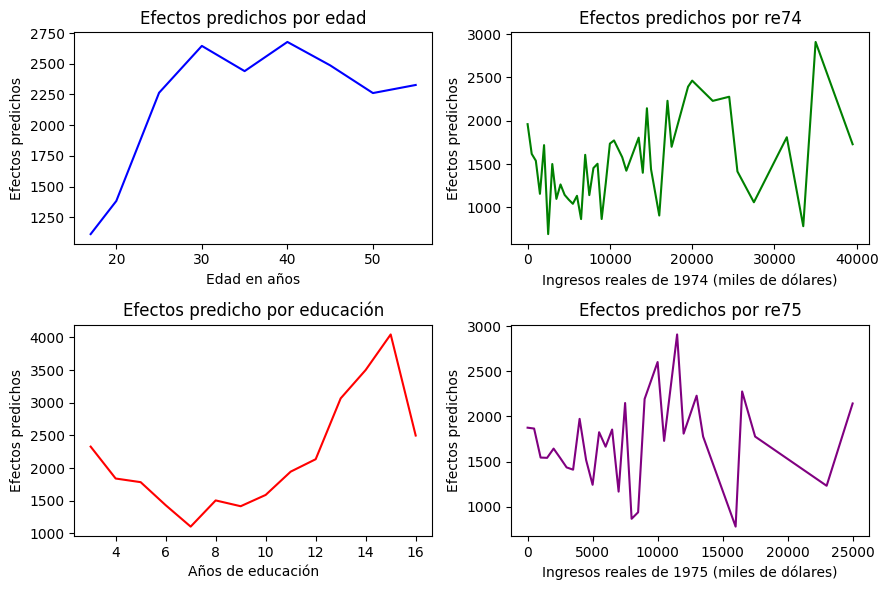

In [198]:
# Gráficamos valores predichos por features
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs = axs.flatten()  # Asegurar acceso fácil a cada subplot

# AGE
axs[0].plot(predicted_effects_age['age_bins'], predicted_effects_age['predicted_effects'], color='blue')
axs[0].set_title("Efectos predichos por edad", fontsize=12)
axs[0].set_xlabel("Edad en años")
axs[0].set_ylabel("Efectos predichos")

# re74
axs[1].plot(predicted_effects_re74['re74_bins'], predicted_effects_re74['predicted_effects'], color='green')
axs[1].set_title("Efectos predichos por re74", fontsize=12)
axs[1].set_xlabel("Ingresos reales de 1974 (miles de dólares)")
axs[1].set_ylabel("Efectos predichos")

# Re75
axs[3].plot(predicted_effects_re75['re75_bins'], predicted_effects_re75['predicted_effects'], color='purple')
axs[3].set_title("Efectos predichos por re75", fontsize=12)
axs[3].set_xlabel("Ingresos reales de 1975 (miles de dólares)")
axs[3].set_ylabel("Efectos predichos")

# EDUCATION
axs[2].plot(predicted_effects_educ['educ'], predicted_effects_educ['predicted_effects'], color='red')
axs[2].set_title("Efectos predicho por educación", fontsize=12)
axs[2].set_xlabel("Años de educación")
axs[2].set_ylabel("Efectos predichos")

plt.tight_layout()
plt.show()